# 04. PyTorch Custom Datasets Exercises

## Resources

These exercises/solutions are based on https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [2]:
# Import torch
import torch
from torch import DeviceObjType, nn

print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else (
    "mps" if torch.mps.is_available() else "cpu"
)
print(device)

2.7.1
mps


## 2. Recreate the data loading functions we built in sections 1, 2, 3 and 4 of notebook 04. You should have train and test DataLoader's ready to use.

### 1. Get data


In [ ]:
from pathlib import Path

# Set up paths
data_path = Path("data/")
image_path = data_path  / "pizza-steak-sushi"

# Create data dir if does not exits
if image_path.is_dir():
    print(f"{image_path} already exists...")
else:
    print(f"{image_path} doesn't exist, creating...")
    image_path.mkdir(exist_ok=True)

data/pizza-steak-sushi doesn't exist, creating...


In [ ]:
import requests

# Download data
with open(data_path / "pizza-steak-sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza-steak-sushi.zip...")
    f.write(request.content)

Downlaoding pizza-steak-sushi.zip...


In [ ]:
from zipfile import ZipFile

# Extract data
with ZipFile(data_path / "pizza-steak-sushi.zip", "r") as z:
    print(f"Extracting pizza-steak-sushi.zip...")
    z.extractall(image_path)

Extracting pizza-steak-sushi.zip...


### 2. Become one with the data

In [10]:
import os

def walk_through_files(dir_path) -> None:
    """Walks through dir_path printing file counts of its content"""
    for dir_path, dir_names, file_names in os.walk(dir_path):
        print(f"There are {len(dir_names)} directories and {len(file_names)} files in {dir_path}")

# Walk through data folder
walk_through_files(image_path)

There are 2 directories and 0 files in data/pizza-steak-sushi
There are 3 directories and 0 files in data/pizza-steak-sushi/test
There are 0 directories and 19 files in data/pizza-steak-sushi/test/steak
There are 0 directories and 31 files in data/pizza-steak-sushi/test/sushi
There are 0 directories and 25 files in data/pizza-steak-sushi/test/pizza
There are 3 directories and 0 files in data/pizza-steak-sushi/train
There are 0 directories and 75 files in data/pizza-steak-sushi/train/steak
There are 0 directories and 72 files in data/pizza-steak-sushi/train/sushi
There are 0 directories and 78 files in data/pizza-steak-sushi/train/pizza


In [11]:
# Setup train and testing paths
train_path = image_path / "train"
test_path = image_path / "test"

train_path, test_path

(PosixPath('data/pizza-steak-sushi/train'),
 PosixPath('data/pizza-steak-sushi/test'))

Image path: data/pizza-steak-sushi/test/pizza/2236338.jpg
Image label: pizza
Image width: 512
Image height: 512
Image size: (512, 512)


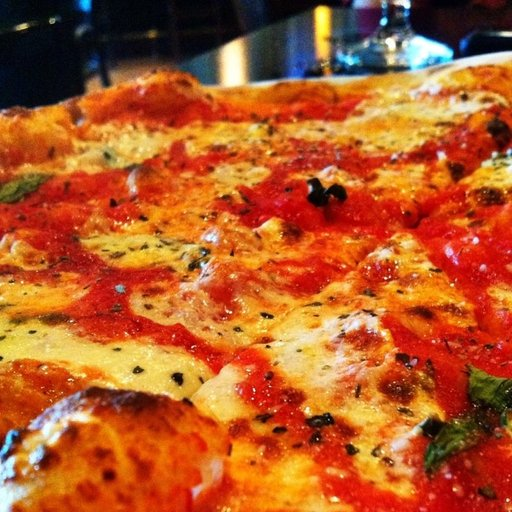

In [66]:
# Visualize an image
import random
from PIL import Image

random.seed(42)

sample_path = random.choice(list(image_path.glob("*/*/*.jpg")))
sample_image = Image.open(sample_path)
sample_label = sample_path.parent.stem

print(f"Image path: {sample_path}")
print(f"Image label: {sample_label}")
print(f"Image width: {sample_image.width}")
print(f"Image height: {sample_image.height}")
print(f"Image size: {sample_image.size}")
sample_image

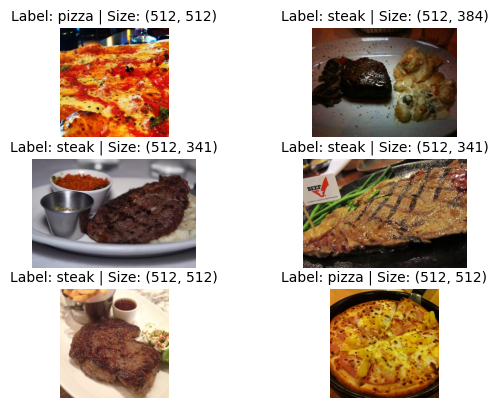

In [89]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt

random.seed(42)

for i in range(1, 7):
    sample_path = random.choice(list(image_path.glob("*/*/*.jpg")))
    sample_label = sample_path.parent.stem
    sample_image = Image.open(sample_path)
    
    plt.subplot(3, 2, i)
    plt.imshow(sample_image)
    plt.title(f"Label: {sample_label} | Size: {sample_image.size}", fontsize=10)
    plt.axis(False)

### 3.1 Transforming data with `torchvision.transforms`

In [86]:
# Write transform for turning images into tensors
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

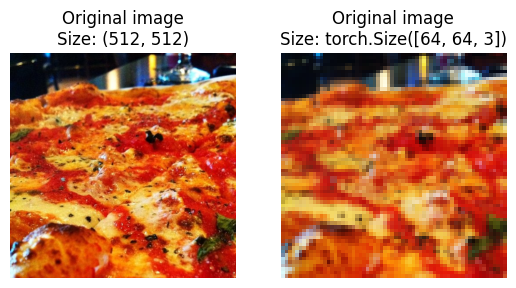

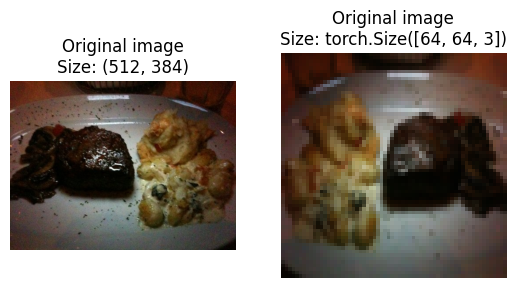

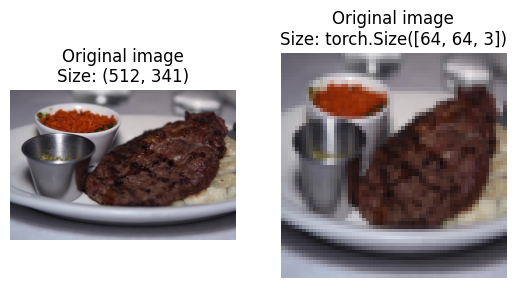

In [117]:
# Write a function to plot transformed images
def plot_and_transform_images_v1(image_path, transforms, nrows: int, seed: int=42):
    random.seed(seed)
    
    sample_paths = random.sample(list(image_path.glob("*/*/*.jpg")), k=nrows)
    
    for sample_path in sample_paths:
        sample_label = sample_path.parent.stem
        
        original_image = Image.open(sample_path)
        transformed_image = transforms(original_image).permute(1, 2, 0)
        
        fig, ax = plt.subplots(1, 2)
        
        ax[0].imshow(original_image)
        ax[0].set_title(f"Original image\nSize: {original_image.size}")
        ax[0].axis(False)
        
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Original image\nSize: {transformed_image.shape}")
        ax[1].axis(False)

plot_and_transform_images_v1(
    image_path=image_path,
    transforms=image_transform,
    nrows=3, 
    seed=42
)

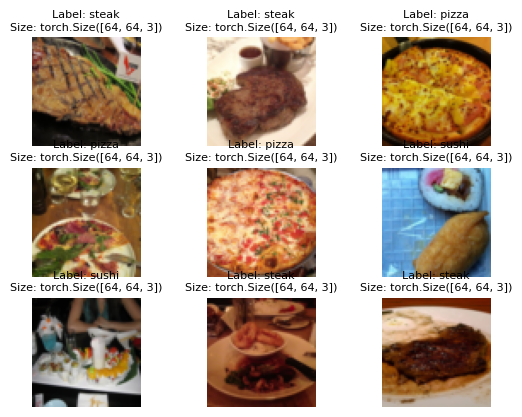

In [118]:
# Write a function to plot transformed images
def plot_and_transform_images_v2(image_path, transforms, nrows: int, ncols: int, seed: int=42):
    for i in range(1, nrows*ncols + 1):
        sample_path = random.choice(list(image_path.glob("*/*/*.jpg")))
        sampel_label = sample_path.parent.stem
        sample_image = Image.open(sample_path)
        
        sample_transformer_image = transforms(img=sample_image).permute(1, 2, 0)
        
        plt.subplot(nrows, ncols, i)
        plt.imshow(sample_transformer_image)
        plt.title(f"Label: {sampel_label}\nSize: {sample_transformer_image.shape}", fontsize=8)
        plt.axis(False)
        
plot_and_transform_images_v2(
    image_path=image_path,
    transforms=image_transform,
    nrows=3, 
    ncols=3,
    seed=42
)

### 3.2 Load image data using `ImageFolder`

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:

1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [11]:
# Use ImageFolder to create dataset(s)


In [12]:
# Get class names as a list


In [13]:
# Can also get class names as a dict


In [14]:
# Check the lengths of each dataset


In [15]:
# Turn train and test Datasets into DataLoaders


In [16]:
# How many batches of images are in our data loaders?
